# Outline

The common wisdom is that one should use deep-learning when there is "enough" data available and otherwise rely on conventional machine-learning approaches. This of course makes perfect sense and it should be intuitive why this is the case. That being said, it is interesting to see how far one can push things and what happens in the case of tasks with intermediate dataset sizes.

One thing that I have personally observed is that regression tasks, which often by nature happen to involve fewer categorical features, are more tolerant of smaller datasets when approached using deep learning. In contrast, classification tasks and specifically binary classification tasks with several categorical features.

Here I explore using a fully-connected network for the Telco Churn problem to see how far things can be pushed. Specifically, I want to use this to examine the ability of DNNs in doing feature extraction automatically.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

import utilities as utils

<br><br><br>

# Dataset

## Load Data

In [2]:
df = pd.read_csv("telco_customer_churn.csv")
display(df.sample(10))

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4795,6532-YLWSI,Female,0,Yes,No,53,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),20.80,1021.8,Yes
652,5845-BZZIB,Male,0,Yes,Yes,35,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.10,655.3,No
2858,9512-PHSMG,Female,0,Yes,No,10,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.55,252.75,No
1621,6352-TWCAU,Female,0,No,No,35,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,86.45,3029.1,Yes
3962,8972-HJWNV,Female,1,Yes,No,7,Yes,Yes,Fiber optic,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.55,646.85,Yes
537,5844-QVTAT,Female,0,Yes,Yes,33,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,Yes,Mailed check,58.45,1955.4,No
4506,5329-KRDTM,Male,1,Yes,No,72,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),77.35,5396.25,No
5131,5980-NOPLP,Female,0,Yes,No,44,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,96.10,4364.1,Yes
6695,6253-GNHWH,Female,0,Yes,Yes,71,Yes,Yes,DSL,Yes,...,Yes,Yes,No,No,Two year,No,Mailed check,71.10,5224.95,No
74,5630-AHZIL,Female,0,No,Yes,3,Yes,No,DSL,Yes,...,No,Yes,No,Yes,Month-to-month,Yes,Bank transfer (automatic),64.50,177.4,No


## Explore and Clean Up Data

In [3]:
print(f"Num Rows: {len(df.index)}")

for col in df.columns:
    if df[col].dtype == np.object:
        print(f"\t{col:24}{str(df[col].dtype):16}{pd.unique(df[col])}")
    else:
        print(f"\t{col:24}{str(df[col].dtype):16}")

Num Rows: 7043
	customerID              object          ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
	gender                  object          ['Female' 'Male']
	SeniorCitizen           int64           
	Partner                 object          ['Yes' 'No']
	Dependents              object          ['No' 'Yes']
	tenure                  int64           
	PhoneService            object          ['No' 'Yes']
	MultipleLines           object          ['No phone service' 'No' 'Yes']
	InternetService         object          ['DSL' 'Fiber optic' 'No']
	OnlineSecurity          object          ['No' 'Yes' 'No internet service']
	OnlineBackup            object          ['Yes' 'No' 'No internet service']
	DeviceProtection        object          ['No' 'Yes' 'No internet service']
	TechSupport             object          ['No' 'Yes' 'No internet service']
	StreamingTV             object          ['No' 'Yes' 'No internet service']
	StreamingMovies         object  

In [4]:
# Are there non-numberical values in "Total Charges"?
print("Number of non-numerical rows in \"TotalCharges\": {}".format(
    np.sum(pd.to_numeric(df["TotalCharges"], errors="coerce").isnull().values)))
nan_total_charges = pd.to_numeric(df["TotalCharges"], errors="coerce").isnull()
display(nan_total_charges)

Number of non-numerical rows in "TotalCharges": 11


0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

In [5]:
# Convert, for example, gender into a one-hot-encoding DataFrame:
gender_ohe_df = pd.get_dummies(df["gender"], prefix=None, drop_first=False)
display(gender_ohe_df.sample(5))

,Female,Male
802,0,1
5135,1,0
5579,1,0
1509,0,1
6478,1,0


## Compile Features and Label DataFrames:

In [6]:
# First, remove rows that have "NaN" in "TotalCharges":
new_df = df[~nan_total_charges].reset_index()

new_df["TotalCharges"] = pd.to_numeric(new_df["TotalCharges"], errors="raise")

print(new_df["TotalCharges"].dtype)
print(f"Decrease of {len(df.index)} --> {len(new_df.index)} in the number of rows...")

float64
Decrease of 7043 --> 7032 in the number of rows...


In [7]:
# Labels:
label_df = new_df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)
display(label_df.sample(5))

6766    0
4652    1
14      0
1108    0
1732    0
Name: Churn, dtype: int64

In [8]:
cleanedup_df = new_df[["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]]

# Categorical to one hot encoding:
ohe_dfs = {}
categorical_columns = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", 
    "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", 
    "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod"]
for col in categorical_columns:
    ohe_dfs[col] = pd.get_dummies(new_df[col], prefix=col.lower(), drop_first=False)
    print(f"\t{col:32}{len(ohe_dfs[col].columns)}")

	gender                          2
	Partner                         2
	Dependents                      2
	PhoneService                    2
	MultipleLines                   3
	InternetService                 3
	OnlineSecurity                  3
	OnlineBackup                    3
	DeviceProtection                3
	TechSupport                     3
	StreamingTV                     3
	StreamingMovies                 3
	Contract                        3
	PaperlessBilling                2
	PaymentMethod                   4


In [9]:
# Concatenate all the dataframes:
cleanedup_df = pd.concat([*list(ohe_dfs.values()), cleanedup_df], axis=1)

print(f"Number of Rows: {len(cleanedup_df.index)}")
# for col in cleanedup_df.columns:
#     print(f"\t{col:32}")
display(cleanedup_df)

Number of Rows: 7032


,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,phoneservice_No,phoneservice_Yes,multiplelines_No,multiplelines_No phone service,...,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,1,0,0,1,1,0,1,0,0,1,...,0,1,0,0,1,0,0,1,29.85,29.85
1,0,1,1,0,1,0,0,1,1,0,...,1,0,0,0,0,1,0,34,56.95,1889.50
2,0,1,1,0,1,0,0,1,1,0,...,0,1,0,0,0,1,0,2,53.85,108.15
3,0,1,1,0,1,0,1,0,0,1,...,1,0,1,0,0,0,0,45,42.30,1840.75
4,1,0,1,0,1,0,0,1,1,0,...,0,1,0,0,1,0,0,2,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0,1,0,1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,24,84.80,1990.50
7028,1,0,0,1,0,1,0,1,0,0,...,0,1,0,1,0,0,0,72,103.20,7362.90
7029,1,0,0,1,0,1,1,0,0,1,...,0,1,0,0,1,0,0,11,29.60,346.45
7030,0,1,0,1,1,0,0,1,0,0,...,0,1,0,0,0,1,1,4,74.40,306.60


## Features and Labels Arrays:

In [10]:
dataset_size = len(cleanedup_df.index)
feature_names = cleanedup_df.columns

features_array = cleanedup_df.values.astype(np.float32)
labels_array = label_df.values.astype(np.int32)

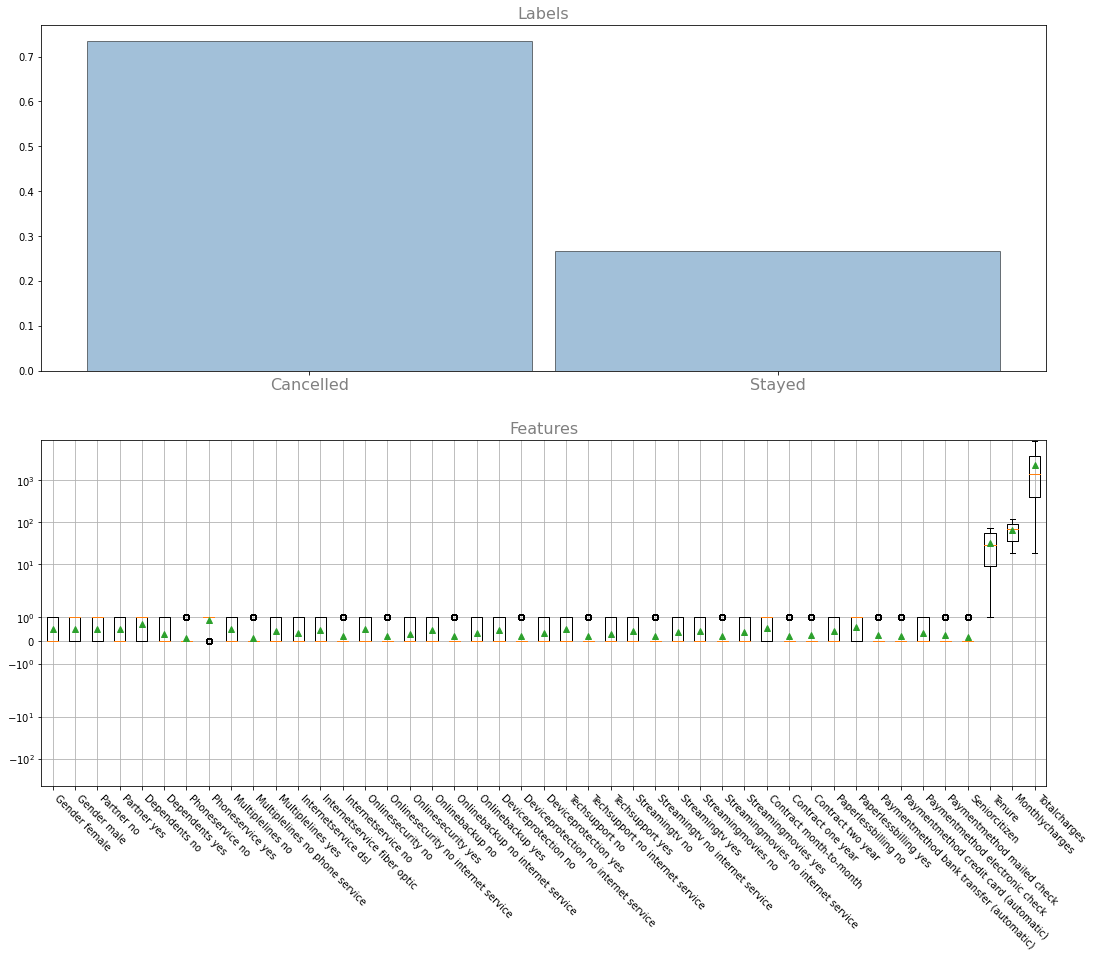

In [11]:
fig = plt.figure(figsize=(18., 14.))
#
ax = plt.subplot(2, 1, 1)
ax.set_title("Labels", fontsize=16, color="gray")
ax.hist(labels_array, bins=[-0.5, 0.5, 1.5], rwidth=0.95, align="mid", density=True,
        edgecolor="black", color="steelblue", alpha=0.5)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Cancelled", "Stayed"], fontsize=16, color="gray")
#
ax = plt.subplot(2, 1, 2)
ax.set_title("Features", fontsize=16, color="gray")
ax.boxplot(features_array, showmeans=True)
ax.set_xticks(1 + np.arange(len(feature_names)))
ax.set_xticklabels([x.replace("_", " ").capitalize() for x in feature_names], 
                   ha="left", va="top", rotation=-45, fontsize=10)
ax.grid()
ax.set_axisbelow(True)
ax.set_yscale("symlog")
#
plt.show()

<br><br><br>

# Prepare Data

## Shuffle

In [12]:
# Create a shuffle mask
shuffle_mask = np.arange(dataset_size)
np.random.shuffle(shuffle_mask)

features_array = features_array[shuffle_mask]
labels_array = labels_array[shuffle_mask]

## Split

In [13]:
test_set_fraction = 0.2

split_mask = np.where(np.random.sample(dataset_size) >= test_set_fraction, True, False)
x_train = features_array[split_mask]
y_train = labels_array[split_mask]
x_test = features_array[np.logical_not(split_mask)]
y_test = labels_array[np.logical_not(split_mask)]

print(f"\t Train set features: {x_train.shape}")
print(f"\t Train set labels:   {y_train.shape}")
print(f"\t Test set features:  {x_test.shape}")
print(f"\t Test set labels:    {y_test.shape}")

	 Train set features: (5653, 45)
	 Train set labels:   (5653,)
	 Test set features:  (1379, 45)
	 Test set labels:    (1379,)


## Normalize:

In [14]:
x_train_means = np.mean(x_train, axis=0)
x_train_stds = np.std(x_train, axis=0)

def normalize_input(x, means=x_train_means, stds=x_train_stds):
    """Normalize the input features.
    """
    means = means[np.newaxis,:]
    stds = stds[np.newaxis,:]
    x = x - means
    return np.divide(x, stds, out=np.zeros_like(x), where=(stds != 0))

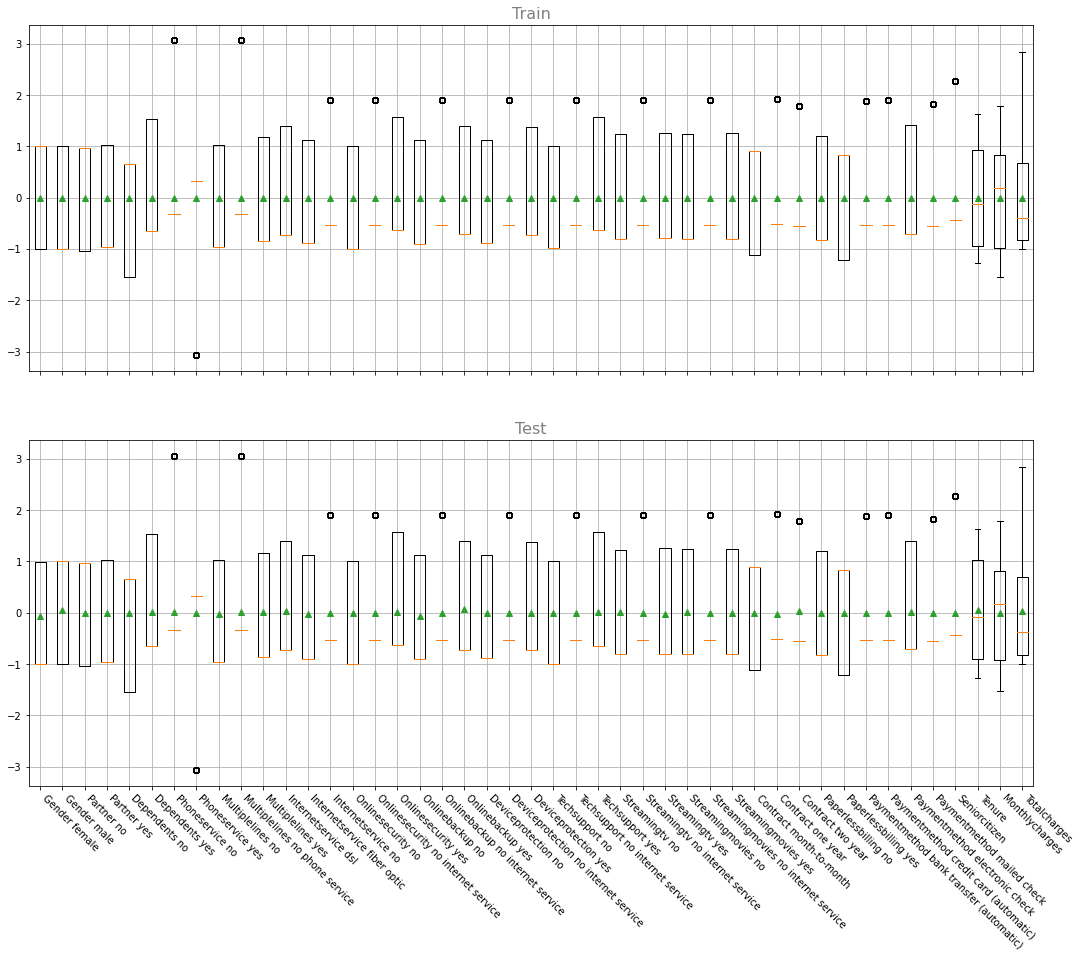

In [15]:
fig = plt.figure(figsize=(18., 14.))
#
ax = plt.subplot(2, 1, 1)
ax.set_title("Train", fontsize=16, color="gray")
ax.boxplot(normalize_input(x_train), showmeans=True)
ax.set_xticks(1 + np.arange(len(feature_names)))
ax.set_xticklabels([])
# ax.set_xticklabels([x.replace("_", " ").capitalize() for x in feature_names], 
#                    ha="left", va="top", rotation=-45, fontsize=10)
ax.grid()
ax.set_axisbelow(True)
ax.set_yscale("linear")
#
ax = plt.subplot(2, 1, 2)
ax.set_title("Test", fontsize=16, color="gray")
ax.boxplot(normalize_input(x_test), showmeans=True)
ax.set_xticks(1 + np.arange(len(feature_names)))
ax.set_xticklabels([x.replace("_", " ").capitalize() for x in feature_names], 
                   ha="left", va="top", rotation=-45, fontsize=10)
ax.grid()
ax.set_axisbelow(True)
ax.set_yscale("linear")
#
plt.show()

<br><br><br>

# Predict Customer Churn

## Logistic Regression

Let's first use logistic regression to establish a baseline for comparisons. 

Instead of using other Python libraries such as SciKit Learn (sklearn), I use TensorFlow.

In [16]:
inputs = tf.keras.Input(
    shape=(len(feature_names),),
    name="input")
outputs = tf.keras.layers.Dense(
    2, 
    activation=tf.keras.activations.softmax,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None,
    bias_regularizer=None,
    name="output"
)(inputs)

logistic_regression_model = tf.keras.Model(
    inputs=inputs, 
    outputs=outputs,
    name="boston_house_appraiser")

In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, name="crossentropy")
metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    utils.SparseCategoricalTP(thresholds=None, name="TP"),
    utils.SparseCategoricalFN(thresholds=None, name="FN"),
    utils.SparseCategoricalFP(thresholds=None, name="FP"),
    utils.SparseCategoricalTN(thresholds=None, name="TN")]

logistic_regression_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [18]:
# Early stoppying callback:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss", 
    min_delta=0.05, 
    patience=100, 
    verbose=1,
    mode="min", 
    baseline=None, 
    restore_best_weights=True)

fit_history = logistic_regression_model.fit(
    x=normalize_input(x_train), 
    y=y_train,
    batch_size=64,
    epochs=1000,
    verbose=0,
    validation_split=0.0,
    shuffle=True,
    class_weight={0: 1.0, 1: 3.0},  # To compensate for class imbalance
    workers=8,
    callbacks=[early_stopping_callback])

Restoring model weights from the end of the best epoch.
Epoch 00121: early stopping


	loss                            0.51959
	accuracy                        0.73822
	TP                              311.0
	FN                              72.0
	FP                              289.0
	TN                              707.0


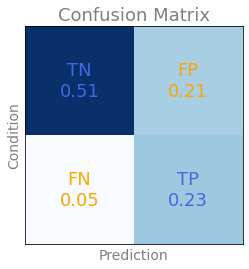

In [19]:
utils.evaluate_model(
    model=logistic_regression_model, 
    features=normalize_input(x_test), 
    labels=y_test)

<br><br><br>

## DNN Classifier Model

Next, we construct a DNN for predicting customer churn.

### Construct Model

In [20]:
inputs = tf.keras.Input(
    shape=(len(feature_names),),
    name="input")
x = tf.keras.layers.Dense(
    64, 
    activation=tf.keras.activations.tanh,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None, #tf.keras.regularizers.L1(l1=0.1),
    bias_regularizer=None,
    name="dense_1"
)(inputs)
# x = tf.keras.layers.Dropout(rate=0.2, name="dropout_1")(x)
x = tf.keras.layers.Dense(
    32, 
    activation=tf.keras.activations.tanh,
    use_bias=False, #True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None, #tf.keras.regularizers.L2(l2=0.01),
    bias_regularizer=None,
    name="dense_2"
)(x)
x = tf.keras.layers.Dropout(rate=0.2, name="dropout_2")(x)
outputs = tf.keras.layers.Dense(
    2, 
    activation=tf.keras.activations.softmax,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None, #tf.keras.regularizers.L2(l2=0.0001),
    bias_regularizer=None,
    name="output"
)(x)

model = tf.keras.Model(
    inputs=inputs, 
    outputs=outputs,
    name="boston_house_appraiser")

model.summary(print_fn=(lambda *x: print("\t", *x)))

	 Model: "boston_house_appraiser"
	 _________________________________________________________________
	 Layer (type)                 Output Shape              Param #   
	 input (InputLayer)           [(None, 45)]              0         
	 _________________________________________________________________
	 dense_1 (Dense)              (None, 64)                2944      
	 _________________________________________________________________
	 dense_2 (Dense)              (None, 32)                2048      
	 _________________________________________________________________
	 dropout_2 (Dropout)          (None, 32)                0         
	 _________________________________________________________________
	 output (Dense)               (None, 2)                 66        
	 Total params: 5,058
	 Trainable params: 5,058
	 Non-trainable params: 0
	 _________________________________________________________________


### Compile

In [21]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.0)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, 
    epsilon=1e-07, amsgrad=False, name="Adam")

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, name="crossentropy")

metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    utils.SparseCategoricalTP(thresholds=None, name="TP"),
    utils.SparseCategoricalFN(thresholds=None, name="FN"),
    utils.SparseCategoricalFP(thresholds=None, name="FP"),
    utils.SparseCategoricalTN(thresholds=None, name="TN")]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Fit Model

In [22]:
# Learning rate schedule
def lr_schedule(epoch, lr):
    if (epoch < 10): return lr
    else: return 1.0 * lr
lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(
    schedule=lr_schedule, 
    verbose=0)

# Early stoppying callback:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.05, 
    patience=200, 
    verbose=1,
    mode="min", 
    baseline=None, 
    restore_best_weights=True)

# Fit model
fit_history = model.fit(
    x=normalize_input(x_train), 
    y=y_train,
    batch_size=128,
    epochs=4000,
    verbose=0,
    validation_split=0.2,
    shuffle=True,
    class_weight={0: 1.0, 1: 3.0},  # To compensate for class imbalance
    workers=8,
    callbacks=[
        lr_schedule_callback,
        early_stopping_callback
    ])

utils.evaluate_model(
    model=model, 
    features=normalize_input(x_train), 
    labels=y_train,
    show_confusion_matrix=False)

Restoring model weights from the end of the best epoch.
Epoch 00203: early stopping
	loss                            0.50585
	accuracy                        0.74031
	TP                              1216.0
	FN                              270.0
	FP                              1198.0
	TN                              2969.0


### Training History

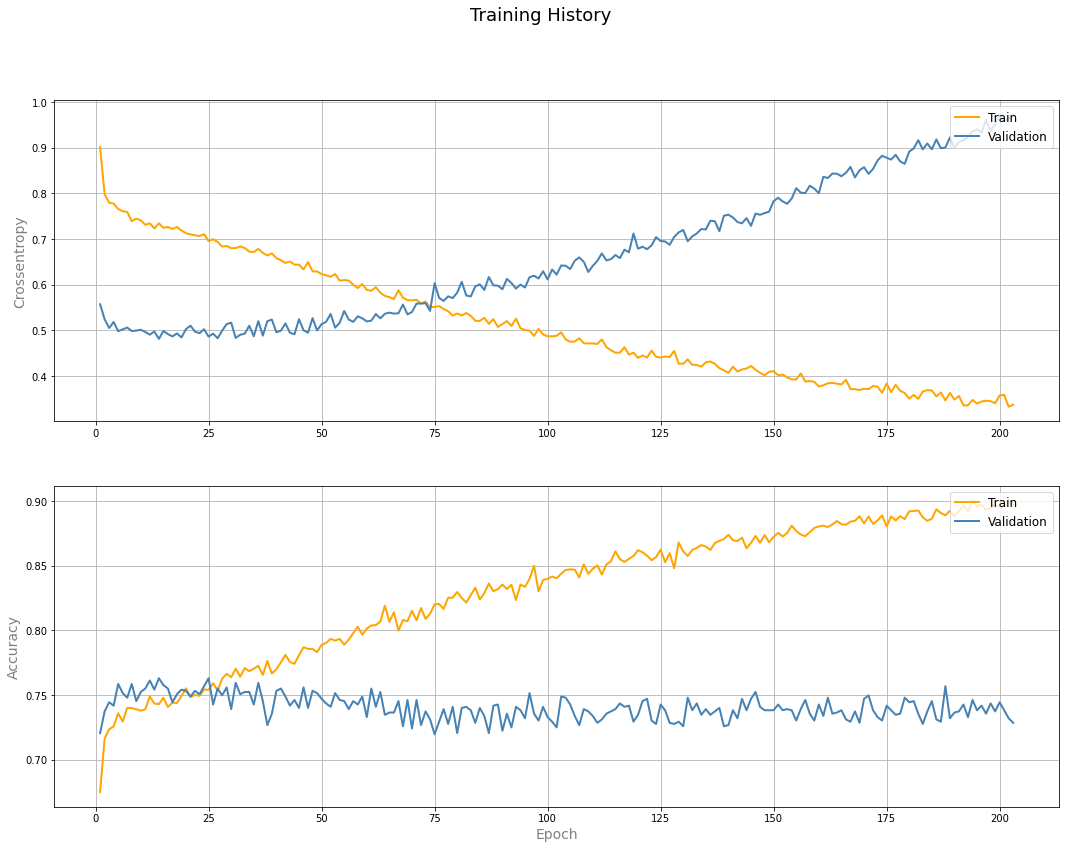

In [23]:
train_losses = fit_history.history["loss"]
val_losses = fit_history.history["val_loss"]
train_rms = fit_history.history["accuracy"]
val_rms = fit_history.history["val_accuracy"]
num_epochs = len(train_losses)
epochs = np.linspace(start=1, stop=num_epochs, num=num_epochs, endpoint=True)

fig = plt.figure(figsize=(18., 13.))
plt.suptitle("Training History", fontsize=18)
#
ax1 = plt.subplot(2, 1, 1)
# ax1.set_title("MSE", fontsize=18)
# ax1.set_xlabel("Epoch", fontsize=14., color="gray")
ax1.set_ylabel("Crossentropy", fontsize=14., color="gray")
ax1.plot(epochs, train_losses, marker="", lw=2.0, color="orange", label="Train")
ax1.plot(epochs, val_losses, marker="", lw=2.0, color="steelblue", label="Validation")
# ax1.set_ylim(-10.0, 100.0)
ax1.grid()
ax1.set_axisbelow(True)
ax1.legend(loc="upper right", fontsize=12)
#
ax2 = plt.subplot(2, 1, 2)
# ax2.set_title("RMS", fontsize=18)
ax2.set_xlabel("Epoch", fontsize=14., color="gray")
ax2.set_ylabel("Accuracy", fontsize=14., color="gray")
ax2.plot(epochs, train_rms, marker="", lw=2.0, color="orange", label="Train")
ax2.plot(epochs, val_rms, marker="", lw=2.0, color="steelblue", label="Validation")
# ax2.set_ylim(-1.0, 20.0)
ax2.grid()
ax2.set_axisbelow(True)
ax2.legend(loc="upper right", fontsize=12)
#
plt.show()

### Model Evaluation

	loss                            0.46711
	accuracy                        0.76722
	TP                              311.0
	FN                              72.0
	FP                              249.0
	TN                              747.0


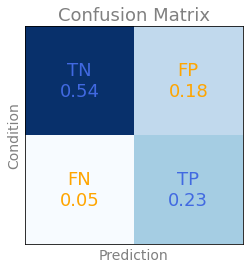

In [24]:
utils.evaluate_model(
    model=model, 
    features=normalize_input(x_test), 
    labels=y_test)